In [1]:
import re
import pandas as pd
from langdetect import detect
from bs4 import BeautifulSoup
import requests
import numpy as np
import nltk
import contractions
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet



## Inicjalizacja projektu
W tej części pobieramy potrzebne paczki do biblioteki nltk.
nltk wykorzystujemy w celu text processingu

In [2]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:1129)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>
[nltk_data] Error loading omw-1.4: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate 

False

## Funkcje pomocnicze
Dalej będą wykorzystywane w kodzie

In [3]:
import string
from nltk.corpus import wordnet

# Usuwa białe spacje i nowe linie
# Parametry
# content - string
# Zwrotka
# string
def trim_content(content: str) -> str:
    removed_spaces = re.sub("\s\s+" , " ", content)
    removed_new_lines = re.sub("\n" , "", removed_spaces)
    return removed_new_lines

# Filtrowanie list
# Zwraca wyfiltrowany obiekt według funkcji podanej w callbacku
# Parametry
# list_obj - lista do przefiltrowania
# callback - funkcja filtrująca, musi zwracać boolean
# Zwrotka
# Wyfiltrowany obiekt
def list_filter(list_obj, callback):
    new_list = list()

    for value in list_obj:
        if callback(value):
            new_list.append(value)

    return new_list

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence, lemmatizer):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

def detect_language(text):
    try:
        language = detect(text)
    except:
        language = 'Other'
    return language

## Pobieranie danych z metacritic
Poniższy kod zwraca recenzje według podanych parametrów (niżej opisane w kodzie)
Kod został dostosowany na potrzeby serwisu metacritic.com
Metacritic blokuje zbyt częste requesty co zostało uwzględnione dalej w kodzie (poniżej odpowiednio opisane)

In [4]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

# Pobieranie danych z metacritic

class MetacriticData:
    def __init__(self):
        self.DEFAULT_RESPONSE = 'Unknown' # Teksotowa zwrotka w przypadku gdy nie ma wystarczającej ilości danych. Wykorzystujemy to dalej by wykryć sytuacje w których kod zadziała w nieoczekiwany sposób przez brak danych na stronie
        self.DEFAULT_RESPONSE_FLOAT = float(-1) # Liczbowa zwrotka w przypadku gdy nie ma wystarczającej ilości danych. Wykorzystujemy to dalej by wykryć sytuacje w których kod zadziała w nieoczekiwany sposób przez brak danych na stronie
        self.search_url = "https://www.metacritic.com/autosearch" # Endpoint do wyszukiwania tytułów
        self.search_headers = { # Nagłówki do zapytania wyszukiwania, bez tego przeglądarka myśli, że jesteśmy robotem i blokuje requesty. Skopiowane z zapytania przeglądarki
            'authority': 'www.metacritic.com',
            'accept': '*/*',
            'x-requested-with': 'XMLHttpRequest',
            'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) '
                        'Chrome/95.0.4638.54 Safari/537.36',
            'content-type': 'application/x-www-form-urlencoded; charset=UTF-8',
            'sec-gpc': '1',
            'origin': 'https://www.metacritic.com',
            'sec-fetch-site': 'same-origin',
            'sec-fetch-mode': 'cors',
            'sec-fetch-dest': 'empty',
            'referer': 'https://www.metacritic.com/game/playstation-4/grand-theft-auto-v',
            'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8',
            'cookie': 'mc_s_s=d_2; OptanonAlertBoxClosed=2021-10-31T12:22:29.841Z; '
                    'ctk=NjE3ZThhOTEwMjAwMDAwMGRmN2Q3M2I4NmRiMg%3D%3D; omniEvents[pageFindingMethod]=Internal:Search; '
                    '_BB.bs=a|3; metapv=3; _BB.d=0|||2; '
                    'OptanonConsent=isIABGlobal=false&datestamp=Sun+Oct+31+2021+13%3A23%3A10+GMT%2B0100+('
                    'Central+European+Standard+Time)&version=6.20.0&hosts=&consentId=316c06a0-7ce1-4feb-8905-2c9cfeec47a2'
                    '&interactionCount=1&landingPath=NotLandingPage&groups=C0001%3A1%2CC0002%3A1%2CC0003%3A1%2CC0004%3A1'
                    '&geolocation=PL%3B24&AwaitingReconsent=false '
        }
        # @TODO: Być może można to usunąć i korzystać z jednego headera
        self.web_scrapping_headers = { # Nagłówki do zapytania pobierania recenzji, bez tego przeglądarka myśli, że jesteśmy robotem i blokuje requesty. Skopiowane z zapytania przeglądarki
            'authority': 'www.metacritic.com',
            'cache-control': 'max-age=0',
            'upgrade-insecure-requests': '1',
            'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) '
                        'Chrome/95.0.4638.54 Safari/537.36',
            'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,'
                    'application/signed-exchange;v=b3;q=0.9',
            'sec-gpc': '1',
            'sec-fetch-site': 'same-origin',
            'sec-fetch-mode': 'navigate',
            'sec-fetch-user': '?1',
            'sec-fetch-dest': 'document',
            'referer': 'https://www.metacritic.com/game/playstation-4/grand-theft-auto-v',
            'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8',
            'cookie': 'mc_s_s=d_2; OptanonAlertBoxClosed=2021-10-31T12:22:29.841Z; '
                    'ctk=NjE3ZThhOTEwMjAwMDAwMGRmN2Q3M2I4NmRiMg%3D%3D; _BB.bs=a|3; metapv=11; _BB.d=0|||10; '
                    'OptanonConsent=isIABGlobal=false&datestamp=Sun+Oct+31+2021+16%3A12%3A56+GMT%2B0100+('
                    'Central+European+Standard+Time)&version=6.20.0&hosts=&consentId=316c06a0-7ce1-4feb-8905-2c9cfeec47a2'
                    '&interactionCount=1&landingPath=NotLandingPage&groups=C0001%3A1%2CC0002%3A1%2CC0003%3A1%2CC0004%3A1'
                    '&geolocation=PL%3B24&AwaitingReconsent=false '
        }

    def _select_content(self, web_content: str) -> str: # Metoda, która zwraca zawartość tekstową strony lub standardową odpowiedź w przypadku nie wykrycia contentu
        if len(web_content) > 0:
            return web_content[0].text
        else:
            return self.DEFAULT_RESPONSE
        
    def _select_content_as_number(self, web_content: str, default_value: int = int(-1)) -> int: # Metoda, która zwraca zawartość tekstową strony w formie liczby lub standardową odpowiedź w przypadku nie wykrycia contentu
        if len(web_content) > 0:
            try:
                return int(web_content[0].text)
            except: 
                return default_value
        
        else:
            return default_value
        
    def _select_reliability(self, ups: str, thumbs: str) -> float: # Wykrywania wiarygodności ocen. Oceniane w sposób podzielenia łapek w górę w stosunku do łapek w dół. Skala 1-0, gdzie 1 tj. wiarygodna 0 tj. mało wiarygodna. W przypadku braku informacji zwraca defaultową odpowiedź
        try:
            reliability = int(ups) / int(thumbs)
    
            return reliability
        except:
            return self.DEFAULT_RESPONSE_FLOAT
        
    def search(self, title: str, platform: str = "PC Game") -> str: # Odpytanie o wyniki wyszukiwania, title - tytuł gry, platform - platforma do recenzji (Defaultowo: PC Game)
        payload = "search_term=" + title + "&image_size=98&search_each=true" # Payload potrzebny do requestu (wykorzystuje tytuł gry)
        response = requests.request("POST", self.search_url, headers=self.search_headers, data=payload) # Zwrotka z pobranymi danymi. Wykorzystuje nagłówki i powyższy payload
        results = response.json()['autoComplete']['results'] # Zwrotka przetworzona, która zwraca tylko wyniki wyszukiwania (Klucze są ID-kami tagów na stronie metacritic)
        selected_platform_results = list_filter(results, lambda elem: elem['refType'] == platform) # Filtrowanie wyników tylko dla wyszukiwanej platformy. Wybranej w parametrze plarform
        exact_title_selected_platform_results = list_filter(selected_platform_results, lambda elem: elem['name'] == title) # Filtrowanie wyników dla tytułów. Wybranego w parametrze title

        if len(exact_title_selected_platform_results) <= 0:
            raise ValueError('The title \'' + title + '\' on platform \'' + platform + '\' was not found.') # W przypadku braku wyników kod zaprzestaje dalszego wywołania

        return exact_title_selected_platform_results[0] # Zwraca pierwszy znaleziony wynik na stronie
    
    def web_scrapping(self, base_url: str, endpoint: str, pages_enabled: bool = False) -> list: # Pobieranie recenzji. Funkcja zwraca listę recenzji znaleziony na stronie gry. base_url - adres strony gry, endpoint - dalsza część adresu odpytania np. podstrona recenzji krytyków lub graczy, pages_enabled - informacja czy paginacja występuje na stronie
        if pages_enabled: # Niektóre strony zawierają paginację, przez co kod musi działać w inny sposób by pobrać wszystkie wyniki.
            have_content = True # Wartość, która pozwala na wykrywania jak długo strona zawiera kolejne dane. Metacritic zwraca kod 200 (OK) dla stron, które nie mają żadnych recenzji, więc nei możńa wykrywać kodu response'a.
            page_index = 0 # Index strony na której się znajdujemy
            response = list() # Zebrane wszystkie recenzje
        
            while have_content: # Dopóki mamy content na stronach
                url = base_url + endpoint + '?page=' + str(page_index) # URL z dodanym parametrem strony
                request = requests.request("GET", url, headers=self.web_scrapping_headers) # Pobieranie zawartości strony
                request_text = request.text # Zawartość strony w formie tekstowej

                if request.status_code != 200: # Jeśli strona metacritic zwróci kod błędu inny niż 200, program zaprzestaje działania. Oznacza to, że nie ma wyników dla wyszukiwanej gry lub metacritic nieodpowiada
                    raise ValueError('Cannot fetch reviews for \'' + url + '\'.')

                if page_index > 50: # Zabezpieczenie przed infinity loopem. Korzystamy tutaj z while'a, wiec warto dodać takie podwójne zabezpieczneie
                    raise ValueError('Probably fetched too many pages for \'' + url + '\'.')

                if 'There are no user reviews yet -' in request_text: # Wykrywa czy istnieje podana fraza na stronie, która wskazuje na to, że nie ma więcej stron
                    have_content = False
                else:
                    response.append(request_text) # Dodaje zwrotkę do arraya response'a, który jest zwracany po wykonaniu pętli

                page_index += 1 # Zwiększenie indeksu strony
            
            return response # Zwracanie znalezionych wyników wyszukiwania

        else: # W przypadku gdy nieoczekujemy paginacji na stronie
            url = base_url + endpoint # Endpoint w tym przypadku bez parametru strony
            request = requests.request("GET", url, headers=self.web_scrapping_headers) # Pobieranie danych

            if request.status_code != 200: # Jeśli strona metacritic zwróci kod błędu inny niż 200, program zaprzestaje działania. Oznacza to, że nie ma wyników dla wyszukiwanej gry lub metacritic nieodpowiada
                raise ValueError('Cannot fetch reviews for \'' + url + '\'.')

            return [request.text] # Zwracanie wyniku w formie arraya, żeby utrzymać spójność zwrokti kodu
        

    def find_reviews(self, web_contents: list, expert: bool = False) -> list: # Wyszukiwanie recenzji na stronie. Parametry: web_contents - lista tekstowej zawartości stron, expert - zdefiniowanie czy szukamy wyników dla recenzji ekspertów czy graczy (true - expert, false - gracz, defaultowo: false - gracz). # Zwraca odpowiedź w formie listy gdzie pierwszy elementr to recenzje krytyków a drugi to recenzje graczy.
        response = list() # Lista znalezionych wyników

        for web_content in web_contents: # Pętla listująca się po podanych contentach strony
            soup = BeautifulSoup(web_content, 'html.parser') # Stworzenie "zupy", z podanych treści, przetwarza nam to HTML-a i dalej możemy łatwiej wyszukiwać zawartości
            main_content = soup.findAll('div', attrs={"id": "main"})[0] # Wyszukanie głównej zawartości strony
            soup_main = BeautifulSoup(str(main_content), 'html.parser') # Stworzenie "zupy", z podanych treści, przetwarza nam to HTML-a i dalej możemy łatwiej wyszukiwać zawartości
            reviews_elements = soup_main.findAll('li', attrs={"class": "review"}) # Wyszukanie wszystkich wyników recenzji

            for review in reviews_elements: # Pętla listująca się po znalezionych recenzjach
                soup_child = BeautifulSoup(str(review), 'html.parser') # Stworzenie "zupy", z podanych treści, przetwarza nam to HTML-a i dalej możemy łatwiej wyszukiwać zawartości
                review_score = self._select_content(soup_child.findAll('div', attrs={"class": "metascore_w"})) # Ocena liczbowa metacritic
                review_content = self._select_content(soup_child.findAll('div', attrs={"class": "review_body"})) # Zawartość
                review_source = self._select_content(soup_child.findAll('div', attrs={"class": "source"})) # Źródło recenzji, występuje tylko dla expertów
                review_name = self._select_content(soup_child.findAll('div', attrs={"class": "name"})) # Nazwa recenzjenta
                review_date = self._select_content(soup_child.findAll('div', attrs={"class": "date"})) # Data recenzji
                review_ups = self._select_content_as_number(soup_child.findAll('span', attrs={"class": "total_ups"}), int(0)) # Ilość łapek w górę
                review_thumbs = self._select_content_as_number(soup_child.findAll('span', attrs={"class": "total_thumbs"}), int(0)) # Ilość wszystkich łapek, nie dostajemy informacji o łapkach w dół
                review_reliabilty = self._select_reliability(review_ups, review_thumbs) # Wiarygodność recenzji

                if expert: # Odopwiednie dodawanie zwrotki zależności czy korzystamy z opinii ekspertów czy graczy. Opinie ekspertów nie mogą być np. oceniane przez innych
                    response.append({
                        'name': trim_content(review_source), 
                        'date': trim_content(review_date),
                        'score': trim_content(review_score), 
                        'content': trim_content(review_content), 
                    })
                else:
                    response.append({
                        'name': trim_content(review_name), 
                        'date': trim_content(review_date),
                        'score': trim_content(review_score), 
                        'content': trim_content(review_content), 
                        'ups': review_ups, 
                        'thumbs': review_thumbs, 
                        'reliability': review_reliabilty
                    })

        return response # Zwrócenie znalezionych recenzji

    def get_reviews(self, title: str, platform: str = 'PC Game') -> list: # Pobieranie recenczji na danej stronie
        results = self.search(title, platform) # Wyszukiwanie konkretnych tytułów (patrz na metodę search)

        scrapped_critic_review = self.web_scrapping(results['url'], '/critic-reviews', False) # Uruchomienie webscrappingu po znalezionych wynikach tytułów - dla recenzji ekspertów. Nie zawierają paginacji. Informację o paginacji niestety możemy tylko ręcznie sprawdzić na stronie metacritic.
        scrapped_user_review = self.web_scrapping(results['url'], '/user-reviews', True) # Uruchomienie webscrappingu po znalezionych wynikach tytułów - dla recenzji graczy. Zawierają paginację. Informację o paginacji niestety możemy tylko ręcznie sprawdzić na stronie metacritic.

        critic_reviews = pd.DataFrame(self.find_reviews(scrapped_critic_review, True)) # Zebrane opinie ekspertów w formie dataframe'a
        user_reviews = pd.DataFrame(self.find_reviews(scrapped_user_review)) # Zebrane opinie graczy w formie dataframe'a

        return [critic_reviews, user_reviews] # Zwraca odpowiedź w formie listy gdzie pierwszy elementr to recenzje krytyków a drugi to recenzje graczy.

## Wyszukiwanie opinii graczy potrzebnych do dalszej części przetwarzania
W kolejnym etapie kodu zapisujemy do odpowiedniej DF-ki opinie graczy. Opinie ekspertów finalnie okazały się zbędne i niepotrzebujemy ich dalej przetwarzać. Wyświetlamy w wynikach cell-ki przykładowego zbioru recenzji.

In [ ]:
def changeScore(df, columnInput, columnOutput):
    df[columnOutput] = np.where(
    df[columnInput].astype(int) <= 4 , "negative", np.where(
    df[columnInput].astype(int) >= 8, "positive", "neutral"))
    return df

In [23]:
#Opinie ekspertów
#MetacriticData().get_reviews('The Sims 4', 'PC Game')[0]
#Opinie userów
# df = MetacriticData().get_reviews('Sackboy: A Big Adventure', 'PS5 Game')[1]
# df = MetacriticData().get_reviews('Mafia: Definitive Edition', 'PC Game')[1]

df_user_review_mafia_definitive_edition_pc = MetacriticData().get_reviews('Mafia: Definitive Edition', 'PC Game')[1]

df_user_review_mafia_definitive_edition_pc

,name,date,score,content,ups,thumbs,reliability
0,welling,"Dec 6, 2020",5,Speaking of cut content... didn't they say it ...,58,58,1.000000
1,beltaniasa,"Oct 31, 2020",3,"But since its a remake, I must rate it in comp...",18,19,0.947368
2,prasannasai,"Sep 26, 2020",10,This is how you do a remake. I know hangar 13 ...,32,50,0.640000
3,marganezz1,"Aug 29, 2020",5,"The game is called a remake, but this is just ...",31,66,0.469697
4,DjBarbarossa,"Nov 15, 2020",6,"The scenario MAF-DE, as in most cases of the e...",9,9,1.000000
...,...,...,...,...,...,...,...
444,Pikoho8642,"Jan 19, 2022",1,How is it possible to have the audacity to rel...,0,0,-1.000000
445,Saj10k,"Feb 5, 2022",1,One patch for the entire time the game was rel...,0,0,-1.000000
446,GamerRap,"Feb 6, 2022",9,I never thought that a remake could be so good...,0,0,-1.000000
447,roten,"Apr 30, 2022",0,this product is not available in your region\r...,0,0,-1.000000


In [29]:
df_user_review_mafia_definitive_edition_pc = changeScore(df_user_review_mafia_definitive_edition_pc, "score", "desc")

<AxesSubplot:xlabel='count', ylabel='desc'>

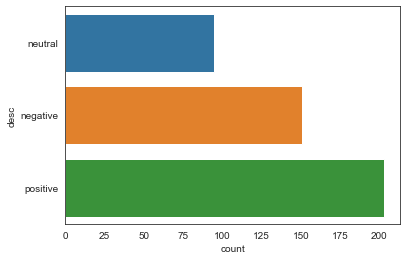

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
sns.countplot(data = df_user_review_mafia_definitive_edition_pc ,y = 'desc')

ValueError: 
Hello Friends!It's not worth the $40 money thrown out.It's neutered by Mafia-DE. Scriptically - absolutely pale characters. Circumcised in many places story. In the time of the original, of course, it looked different. Now - it looks and is played as flawed as possible. In the third part there was at least an open city with a game in it. And DE is by playability chapters with tasksHello Friends!It's not worth the $40 money thrown out.It's neutered by Mafia-DE.Scriptically - absolutely pale characters. Circumcised in many places story. In the time of the original, of course, it looked different.Now - it looks and is played as flawed as possible.In the third part there was at least an open city with a game in it. And DE is by playability chapters with tasks on which you just go non-stop.In the "walking around the city" everything is closed, you will not be allowed even on the tram for npc and the train station doors are locked which was for playing in the original Mafia.For 2020, as a game - it sucks.Trim the original, turning it into a much more boring game. If you want nostalgia - it is better to play the original.It's a DE game of shaming that doesn't cause anything but surprise how much those who did it in general didn't care about the final product and the joys of the players. - Regards.… Expand
                                  ^
Expected end of text, found '$'  (at char 34), (line:1, col:35)

<Figure size 432x288 with 1 Axes>

KeyError: 'score'

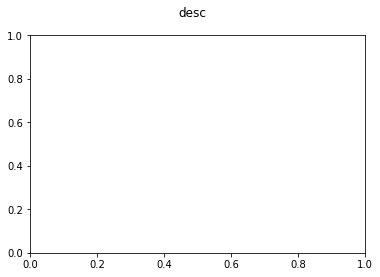

In [13]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
fig.suptitle("desc", fontsize=12)
df_user_review_mafia_definitive_edition_pc["content"].reset_index().groupby("score").count().sort_values(by=
       "index").plot(kind="barh", legend=False,
        ax=ax).grid(axis='x')
plt.show()

In [9]:
df_user_review_Fifa_20 = MetacriticData().get_reviews('FIFA 20', 'PS4 Game')[1]

df_user_review_Fifa_20

,name,date,score,content,ups,thumbs,reliability
0,rumbledore,"Sep 24, 2019",0,EA Just gives us the same game every year with...,67,67,1.0
1,budz007,"Sep 25, 2019",0,I see all these comments saying not to listen ...,50,50,1.0
2,Gfassina99,"Sep 24, 2019",0,EA excels at every game manipulating games and...,39,39,1.0
3,PhillsAcer,"Sep 26, 2019",0,This game hasn't changed since 2017! Just a fe...,32,32,1.0
4,Hangar18,"Sep 24, 2019",0,A shocker!! How can anyone give this game more...,26,26,1.0
...,...,...,...,...,...,...,...
1730,Nilondon777,"Nov 3, 2021",6,its game with male and female football with in...,0,0,-1.0
1731,LeiKazama,"Oct 27, 2021",0,career in fifa for one player - a piece of cod...,0,0,-1.0
1732,Rnoviok,"Dec 4, 2021",1,The third Fifa I've played and the first in wh...,0,0,-1.0
1733,Ferman,"Feb 12, 2022",3,Games from electronic arts are the worst sport...,0,0,-1.0


In [10]:
df_user_review_The_last_of_us = MetacriticData().get_reviews('The Last of Us', 'PS3 Game')[1]

df_user_review_The_last_of_us

,name,date,score,content,ups,thumbs,reliability
0,DemaKosharbekov,"Jun 19, 2020",10,"лучшая игра выходившая на ps3 , Если вы не игр...",18,21,0.857143
1,brad3ngunn,"Jun 14, 2013",10,I don't know what I can really say about this ...,313,407,0.769042
2,Badonkadonk,"Jun 15, 2013",10,"I wouldn't call this game perfect, but it's pr...",65,85,0.764706
3,jakenelson,"Jun 18, 2013",10,I don't think I have ever played a game like t...,29,38,0.763158
4,Qishere,"Jun 14, 2013",10,"You should realize right from the beginning, y...",69,92,0.750000
...,...,...,...,...,...,...,...
2547,asdfmovie5436,"Apr 12, 2022",10,This is a very good game!)))))))))))))))))))))...,0,0,-1.000000
2548,Fabriz,"Apr 20, 2022",0,Trovo la trama pessima e stereotipata come poc...,0,0,-1.000000
2549,trxxs,"Apr 20, 2022",10,If you don't like this game you have the emoti...,0,0,-1.000000
2550,Emanuekis,"May 8, 2022",9,"This review contains spoilers, click expand t...",0,0,-1.000000


In [67]:
from nltk.stem.wordnet import WordNetLemmatizer

def preprocessing(df):

    lemmatizer = nltk.stem.WordNetLemmatizer()
    #detect english and chose only english

    df['Language'] = df['content'].apply(detect_language)
    df = df.loc[df['Language'] == "en"]
    #set type of opinion
    df['desc'] = np.where(
    df['score'].astype(int) <= 4 , "negative", np.where(
    df['score'].astype(int) >= 8, "positive", "neutral"))
    # change text to lower
    df["text_preprocessing"] = df["content"].str.lower()
    #hadn't to had not
    df["text_preprocessing"] = df["text_preprocessing"].apply(lambda x: [contractions.fix(word) for word in x.split()])
    df["text_preprocessing"] = [' '.join(map(str, l)) for l in df["text_preprocessing"]]
    #remove punctuation
    df["text_preprocessing"] = df["text_preprocessing"].apply(lambda x: remove_punctuation(x))
    #remove numbers
    df["text_preprocessing"] = df["text_preprocessing"].str.replace('\d+', '')
    df["text_preprocessing"] = df["text_preprocessing"].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
    #remove mafia
    df["text_preprocessing"] = df["text_preprocessing"].str.replace("mafia", "game")
    #remove double spaces
    df["text_preprocessing"] = df["text_preprocessing"].str.replace("\s\s+", " ")
    #remove stopwords
    df["text_preprocessing"] = df["text_preprocessing"].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in ENGLISH_STOP_WORDS]))
    #tokenization and lemmatization
    df["text_preprocessing"] = df["text_preprocessing"].apply(lambda x: lemmatize_sentence(x, lemmatizer))

    df = df.reset_index()

    return df

In [70]:
df_user_review_mafia_definitive_edition_pc_preprocessed = preprocessing(df_user_review_mafia_definitive_edition_pc)
df_user_review_mafia_definitive_edition_pc_preprocessed

/var/folders/gt/t4t7vkc10wj1379qplxkdq9h0000gn/T/ipykernel_61392/3130443643.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['desc'] = np.where(
/var/folders/gt/t4t7vkc10wj1379qplxkdq9h0000gn/T/ipykernel_61392/3130443643.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_preprocessing"] = df["content"].str.lower()
/var/folders/gt/t4t7vkc10wj1379qplxkdq9h0000gn/T/ipykernel_61392/3130443643.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

,index,name,date,score,content,ups,thumbs,reliability,Language,desc,text_preprocessing
0,0,welling,"Dec 6, 2020",5,Speaking of cut content... didn't they say it ...,57,57,1.000000,en,neutral,speak cut content do say expand kind new missi...
1,1,beltaniasa,"Oct 31, 2020",3,"But since its a remake, I must rate it in comp...",18,19,0.947368,en,negative,remake rate comparsion original game new versi...
2,2,prasannasai,"Sep 26, 2020",10,This is how you do a remake. I know hangar 13 ...,32,50,0.640000,en,positive,remake know hangar do budget rockstar do best ...
3,3,marganezz1,"Aug 29, 2020",5,"The game is called a remake, but this is just ...",31,66,0.469697,en,neutral,game call remake just mediocre game base game ...
4,4,DjBarbarossa,"Nov 15, 2020",6,"The scenario MAF-DE, as in most cases of the e...",9,9,1.000000,en,neutral,scenario mafde case entire game animate cutsce...
...,...,...,...,...,...,...,...,...,...,...,...
346,439,Sogwas03,"Mar 5, 2022",8,"Very good graphically and very alive story, it...",0,0,-1.000000,en,positive,good graphically alive story sad game linear r...
347,440,perrypulus,"Mar 13, 2022",8,The 2nd Mafia game that I played. Even though ...,0,0,-1.000000,en,positive,nd game game play feature kind small adrenalin...
348,441,LeviAkerman,"Mar 19, 2022",8,The interface is wonderful. You have so much i...,0,0,-1.000000,en,positive,interface wonderful information immediately av...
349,442,enesgfb,"Apr 13, 2022",10,This is a masterpiece.It was perfect from star...,0,0,-1.000000,en,positive,masterpieceit perfect start finishi finish gam...


Word Count Median: 28.0
count    351.000000
mean      62.948718
std       73.064846
min        4.000000
25%       15.000000
50%       28.000000
75%       83.000000
max      432.000000
Name: word_count, dtype: float64


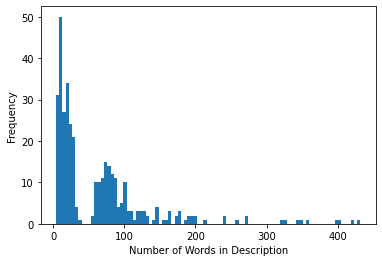

In [69]:
#add a column for the word count
import matplotlib.pyplot as plt

df['word_count'] = df["text_preprocessing"].apply(lambda x: len(str(x).split(" ")))
print("Word Count Median: " + str(df['word_count'].median()))
print(df['word_count'].describe())
x = df['word_count']
n_bins = 95
plt.hist(x, bins=n_bins)
plt.xlabel('Number of Words in Description')
plt.ylabel('Frequency')
plt.show()

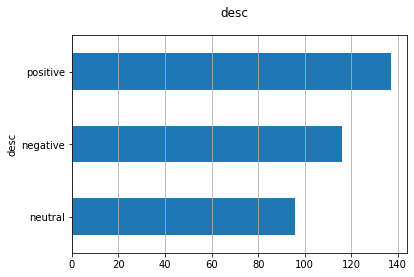

In [29]:
#Najczęstsze słowa
from collections import Counter
cnt = Counter()
for text in df["text_preprocessing"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(30)

[('game', 1720),
 ('original', 464),
 ('story', 325),
 ('like', 279),
 ('good', 269),
 ('remake', 233),
 ('play', 217),
 ('do', 216),
 ('mission', 215),
 ('just', 200),
 ('expand', 189),
 ('world', 163),
 ('city', 162),
 ('great', 162),
 ('…', 151),
 ('character', 150),
 ('car', 148),
 ('time', 148),
 ('look', 137),
 ('graphic', 136),
 ('really', 135),
 ('train', 129),
 ('free', 129),
 ('bad', 120),
 ('feel', 117),
 ('make', 111),
 ('thing', 100),
 ('drive', 98),
 ('gameplay', 97),
 ('new', 94)]

In [98]:
#count vectorizer and Count
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["text_preprocessing"]).toarray()
pd.DataFrame(X, columns = vectorizer.get_feature_names())

counts = pd.DataFrame(X[0].T, index=vectorizer.get_feature_names(), columns=["Count Vectorizer"]).sort_values('Count Vectorizer', ascending=False)
print (counts.head(25))

clusters = MiniBatchKMeans(n_clusters=3).fit_predict(counts)

clustering_model = KMeans(n_clusters=3).fit(counts)
cluster_assignment = clustering_model.labels_

df['cluster_count']=pd.Series(cluster_assignment)
df['cluster_count'] = np.where(
df['cluster_count'].astype(int) == 0 , "negative", np.where(
df['cluster_count'].astype(int) == 1 , "positive", "neutral"))

df['acc_count'] = np.where((df['cluster_count'] ==  df['desc']), True, False)
df.acc_count.value_counts()



          Count Vectorizer
game                    14
mission                  9
way                      5
expand                   4
baseball                 4
train                    4
new                      4
original                 3
car                      3
miss                     3
content                  3
do                       3
buy                      2
show                     2
favour                   2
radio                    2
free                     2
heard                    2
dialog                   2
omerta                   2
remember                 2
lucas                    2
like                     2
kind                     2
regard                   2


/Users/ncheba/Documents/Projekty/Metacritic/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ncheba/Documents/Projekty/Metacritic/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


False    279
True      70
Name: acc_count, dtype: int64

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
transformed = tfidf.fit_transform(df["text_preprocessing"]).toarray()

d = pd.DataFrame(transformed[0].T, index=tfidf.get_feature_names(), columns=["TF-IDF"]).sort_values('TF-IDF', ascending=False)

print (d.head(25))

             TF-IDF
mission    0.283208
baseball   0.258474
game       0.201253
way        0.197840
favour     0.162198
newspaper  0.162198
new        0.152952
dialog     0.151530
omerta     0.151530
content    0.148662
miss       0.139145
heard      0.138090
train      0.137311
regard     0.129237
show       0.122625
radio      0.117345
cool       0.115056
remember   0.112950
kind       0.111000
important  0.111000
car        0.108414
lucas      0.107487
bertone    0.107487
tell       0.097939
buy        0.094713


/Users/ncheba/Documents/Projekty/Metacritic/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Fit 1 clusters
Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters


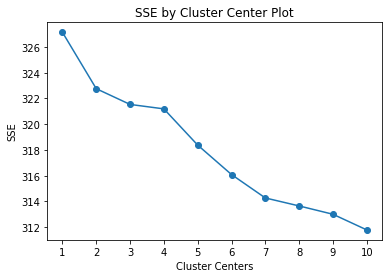

In [32]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

def find_optimal_clusters(data, max_k):
    iters = range(1, max_k+1, 1)

    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))

    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

find_optimal_clusters(transformed, 10)

In [92]:

clusters = MiniBatchKMeans(n_clusters=3).fit_predict(transformed)

clustering_model = KMeans(n_clusters=3).fit(transformed)
cluster_assignment = clustering_model.labels_

def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data).groupby(clusters).mean()

    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

get_top_keywords(transformed, cluster_assignment, tfidf.get_feature_names(), 20)
get_top_keywords(transformed, clusters, tfidf.get_feature_names(), 20)
df['cluster_TDIDF']=pd.Series(cluster_assignment)
df['cluster_TDIDF'] = np.where(
df['cluster_TDIDF'].astype(int) == 0 , "negative", np.where(
df['cluster_TDIDF'].astype(int) == 2 , "positive", "neutral"))

df['acc_tdidf'] = np.where((df['cluster_TDIDF'] ==  df['desc']), True, False)
df.acc_tdidf.value_counts()




Cluster 0
graphic,gameplay,look,great,just,play,thing,time,remake,good,do,car,character,original,story,feel,mission,really,like,game

Cluster 1
worth,like,voice,act,amaze,love,do,atmosphere,hangar,nice,gameplay,original,graphic,play,best,story,great,remake,good,game

Cluster 2
ride,do,release,linear,cut,short,tram,dead,plot,freeride,story,city,just,walk,version,world,train,free,original,game

Cluster 0
addition,release,apparently,moment,product,ride,bought,spoil,do,abandon,original,train,plot,city,streetcar,year,finish,free,dead,game

Cluster 1
hangar,nice,time,mission,character,just,feel,gameplay,do,best,really,graphic,like,play,original,great,remake,story,good,game

Cluster 2
open,just,linear,cut,city,ride,player,plot,short,story,walk,freeride,tram,mission,version,train,free,world,original,game


/Users/ncheba/Documents/Projekty/Metacritic/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ncheba/Documents/Projekty/Metacritic/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


False    305
True      44
Name: acc_tdidf, dtype: int64

In [34]:
clustering_model

KMeans(n_clusters=3)

In [35]:
clusters

array([2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1,
       2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1,
       2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 1, 1, 1, 2, 0, 0, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2,
       2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1,
       2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0,

In [100]:
#BERT
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('bert-large-nli-mean-tokens')
corpus_embeddings = embedder.encode(df["content"])

In [78]:
#clustering
clustering_model = KMeans(n_clusters=3)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_
get_top_keywords(transformed, cluster_assignment, tfidf.get_feature_names(), 40)


Cluster 0
touch,straight,open,freeride,mission,look,product,thing,finish,change,gameplay,definitive,graphic,classic,cut,ruin,plot,make,hangar,year,linear,spoil,good,edition,bad,free,walk,remake,short,stupid,just,release,version,dead,play,do,story,world,original,game

Cluster 1
edition,want,gameplay,change,linear,way,freeride,mode,thing,make,graphic,drive,shoot,new,plot,feel,bad,ride,really,great,tram,expand,character,time,look,world,remake,free,play,good,car,just,do,city,train,story,mission,like,original,game

Cluster 2
amazing,think,incredible,quality,city,sound,far,worth,voice,day,masterpiece,beautiful,awesome,act,do,amaze,time,pretty,well,enjoy,job,character,recommend,feel,hangar,atmosphere,like,love,gameplay,original,nice,really,graphic,play,best,story,great,remake,good,game


/Users/ncheba/Documents/Projekty/Metacritic/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Fit 1 clusters
Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters


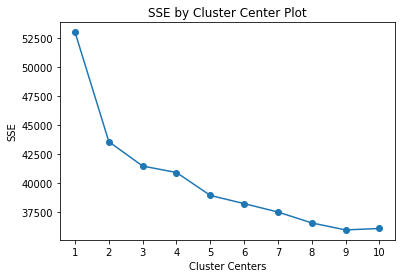

In [102]:
find_optimal_clusters(corpus_embeddings, 10)

In [84]:
df['cluster_BERT_prec']=pd.Series(cluster_assignment)
df['cluster_BERT_prec'] = np.where(
df['cluster_BERT_prec'].astype(int) == 0 , "negative", np.where(
df['cluster_BERT_prec'].astype(int) == 2 , "positive", "neutral"))

df['acc'] = np.where((df['cluster_BERT_prec'] ==  df['desc']), True, False)
df.acc.value_counts()


True     187
False    162
Name: acc, dtype: int64